# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°3 - Predicción lineal
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# TODO
* Limpiar helper
* Grabar las cosas posta

# 1. Obtención de las grabaciones
En primer lugar, se graban los dos sonidos a utilizar en el trabajo. Estos son una grabación sostenida del fonema /a/ y otra del fonema /sh/. Ambas frecuencias de muestreo fueron fijadas en $16kHz$.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from src.helper import print_signal
from scipy.linalg import solve_toeplitz
import scipy.signal as sps

## 1.1 Grabación de /a/

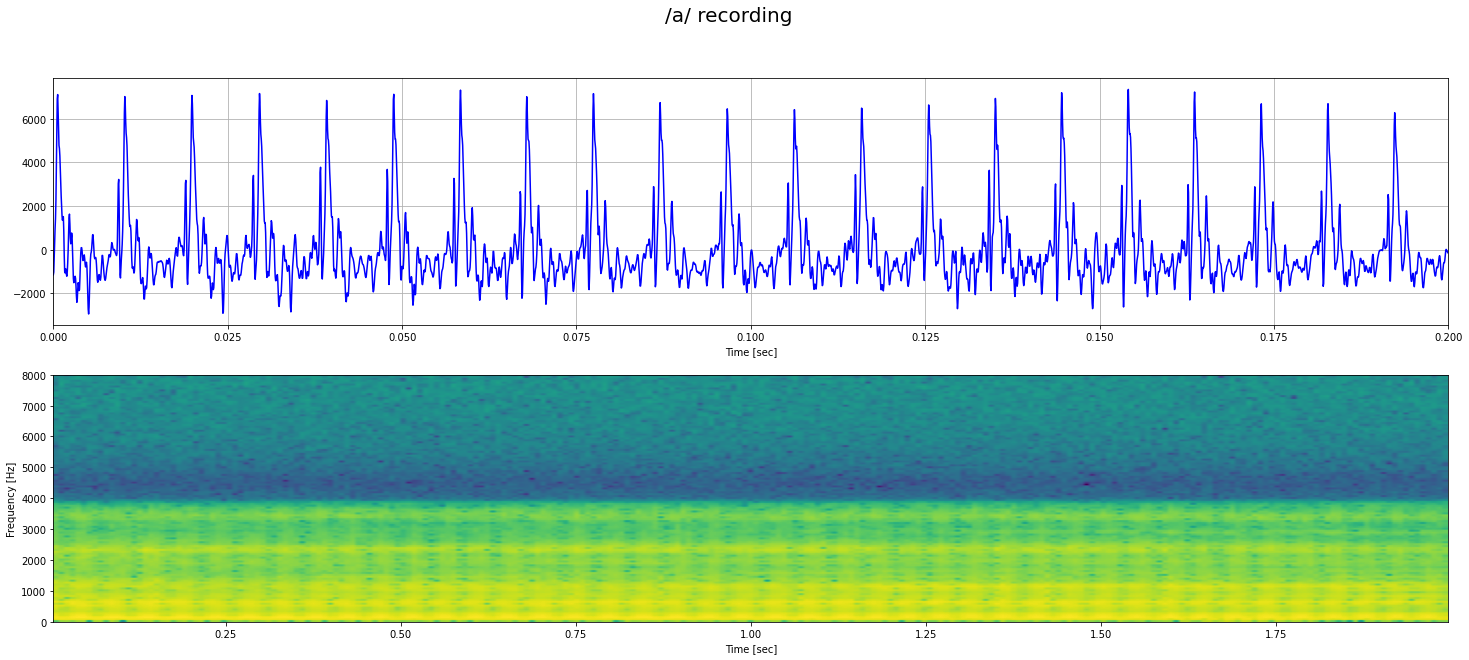

In [119]:
# /a/ sound
a_fs, a_sound = wavfile.read('./assets/a_sound.wav')

# Plot signal
print_signal(np.arange(len(a_sound)) / a_fs, a_sound, '/a/ recording', samplerate=a_fs, xlim=(0,len(a_sound)/10/a_fs))

In [17]:
print('/a/ original recording')
Audio('./assets/a_sound.wav')

/a/ original recording


## 1.2 Grabación de /sh/

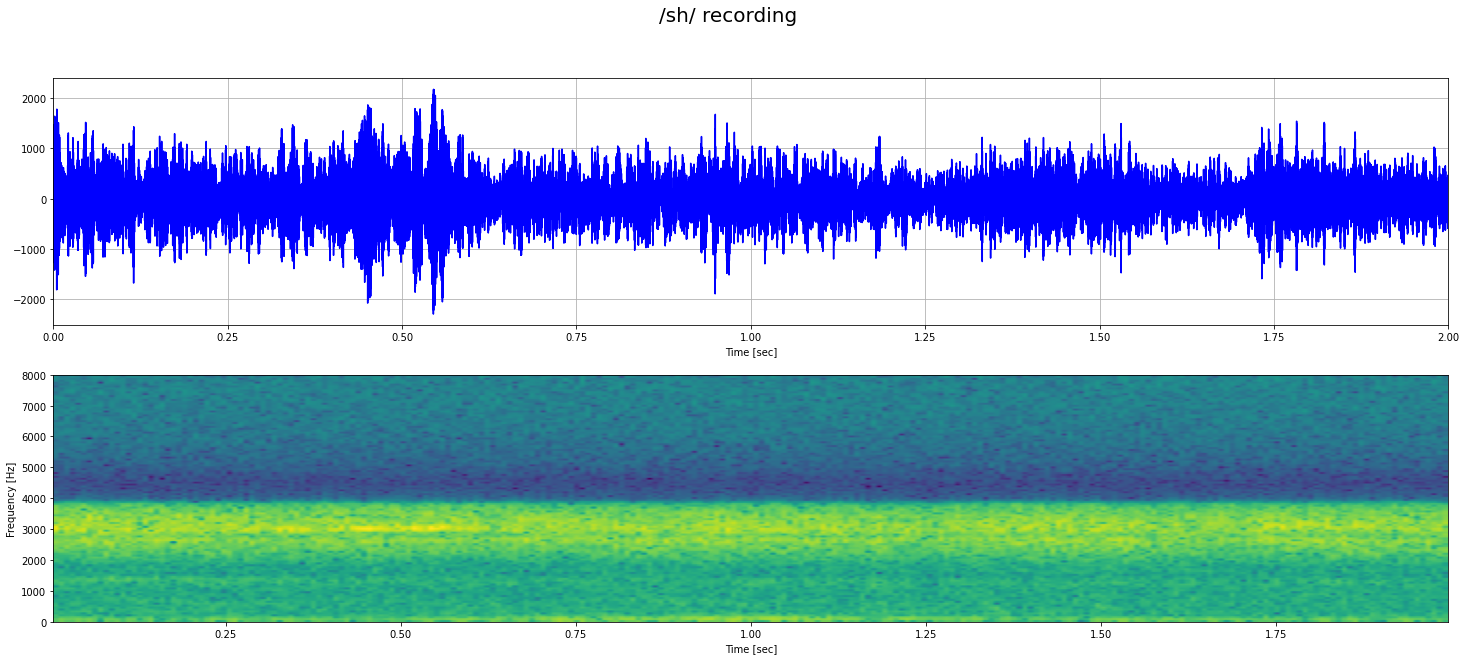

In [18]:
# /sh/ sound
sh_fs, sh_sound = wavfile.read('./assets/sh_sound.wav')

# Plot signal
print_signal(np.arange(len(sh_sound)) / sh_fs, sh_sound, '/sh/ recording', samplerate=sh_fs, xlim=(0,len(sh_sound)/sh_fs))

In [19]:
print('/sh/ original recording')
Audio('./assets/sh_sound.wav')

/sh/ original recording


# 2. Predicción forward
A continuación se realiza una predicción del tipo forward sobre cada una de las pistas de audio grabadas. Se realiza un barrido respecto del largo del filtro $M$, de forma tal de poder apreciar cómo varía el MSE mínimo $J_o$ al aumentar el orden.

En primer lugar, se resta la media a cada una de las señales para poder cumplir con la hipótesis de media nula.

In [86]:
# Substract mean to signals
a_sound = a_sound - np.mean(a_sound)
sh_sound = sh_sound - np.mean(sh_sound)

# Normalize signals
a_norm = a_sound / np.iinfo(np.int16).max
sh_norm = sh_sound / np.iinfo(np.int16).max

Se supone a la señal localmente estacionaria. Luego se pueden aplicar las ecuaciones de predicción forward estacionarias.

In [108]:
def forward_prediction_filter(signal, M):
    """
    Compute forward predicion filter coefficients for a given signal and order.
    """
    N = len(signal)
    
    # Compute autocorrelation vector
    r = sps.correlate(signal, signal, method='fft',mode='same')[N//2:] / N
    
    # Forward autocorrelation vector
    # rf = r*
    rf = np.conjugate(r[1:M+1])
    
    # Solve system
    # R.ao = -rf
    ao = solve_toeplitz(r[:M], -1*rf)
    
    # Now get prediction error
    # jo = r(0) + r^H.ao
    jo = r[0] + np.dot(r[1:M+1], np.transpose(ao))
        
    return ao, jo

In [113]:
orders = [i for i in range(1,400)]
errors = {'a':[], 'sh':[]}

for o in orders:
    # /a/ sound predictor
    _, e = forward_prediction_filter(a_norm, o)
    errors['a'].append(e)
    
    # /sh/ sound predictor
    _, e = forward_prediction_filter(sh_norm, o)
    errors['sh'].append(e)

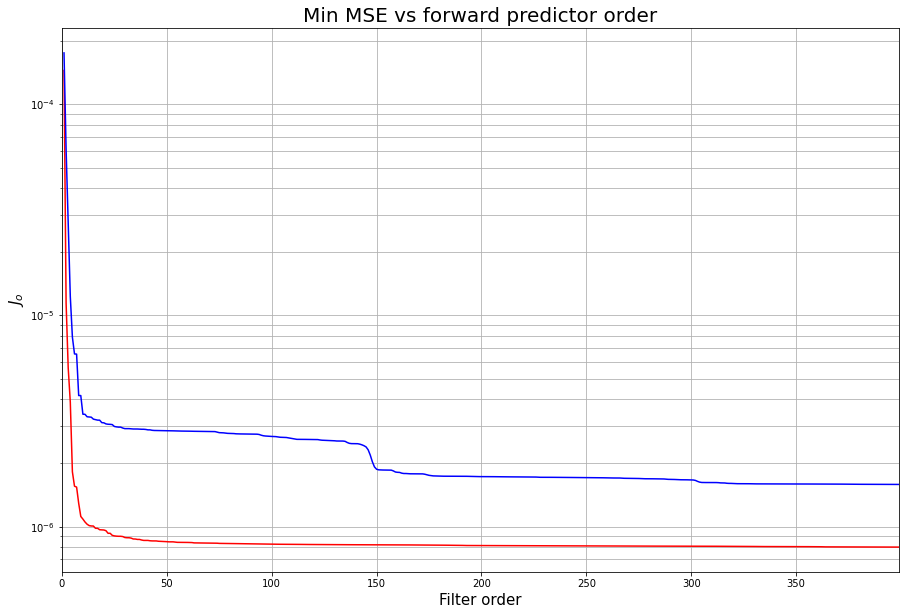

In [118]:
plt.figure(figsize=(15,10))
plt.xlim(0, np.max(orders))
plt.grid(which='both', axis='both')
plt.title('Min MSE vs forward predictor order', fontsize=20)
plt.xlabel('Filter order', fontsize=15)
plt.ylabel('$J_o$', fontsize=15)
plt.semilogy(orders, errors['sh'], color='red')
plt.semilogy(orders, errors['a'], color='blue')
plt.show()

In [136]:
def get_forward_error(signal, a):
    # Get error filter coefficients
    a_e = np.concatenate(([1],a))
    return sps.lfilter(a_e, [1], signal)

In [149]:
a75, _ = forward_prediction_filter(a_norm, 12)
e75 = get_forward_error(a_norm, a75)

a250, _ = forward_prediction_filter(a_norm, 75)
e250 = get_forward_error(a_norm, a250)

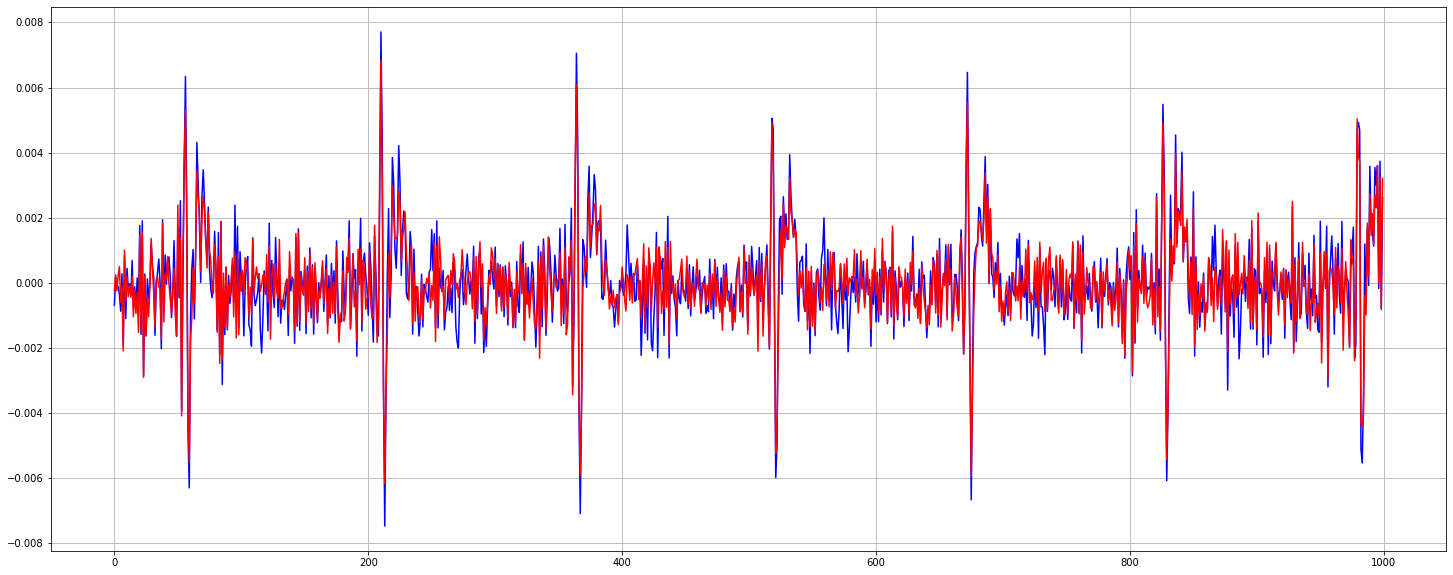

In [152]:
plt.figure(figsize=(25,10))
plt.plot(e75[5000:6000], color='blue')
plt.plot(e250[5000:6000], color='red')
plt.grid(which='both', axis='both')
plt.plot();